### Import packages & load data

In [7]:
import pandas as pd
import numpy as np

from utils import z_normalize_column, synchronize_trials, remove_artifacts_from_column, bandpass, segment_column, decompose_segment, extract_features, train
from plots import plot_preprocessing, plot_sample_durations, plot_eeg_gradcpt_time_diff

eeg_data_1 = pd.read_csv('data/subject2/muselsl-session1-1.csv')
gradcpt_data_1 = pd.read_csv('data/subject2/gradcpt-session1-1.csv')
eeg_data_2 = pd.read_csv('data/subject2/muselsl-session1-2.csv')
gradcpt_data_2 = pd.read_csv('data/subject2/gradcpt-session1-2.csv')
eeg_data_3 = pd.read_csv('data/subject2/muselsl-session1-3.csv')
gradcpt_data_3 = pd.read_csv('data/subject2/gradcpt-session1-3.csv')

channels = ['AF8'] 

# Add a column to indicate the trial number
eeg_data_1['trial'] = 1
gradcpt_data_1['trial'] = 1
eeg_data_2['trial'] = 2
gradcpt_data_2['trial'] = 2
eeg_data_3['trial'] = 3
gradcpt_data_3['trial'] = 3

### Syncrhonize the start times of the EEG and GradCPT data

In [8]:
eeg_data_1, gradcpt_data_1 = synchronize_trials(eeg_data_1, gradcpt_data_1)
eeg_data_2, gradcpt_data_2 = synchronize_trials(eeg_data_2, gradcpt_data_2)
eeg_data_3, gradcpt_data_3 = synchronize_trials(eeg_data_3, gradcpt_data_3)

eeg_data_1['AF8_normal'] = z_normalize_column(eeg_data_1['AF8'])
eeg_data_2['AF8_normal'] = z_normalize_column(eeg_data_2['AF8'])
eeg_data_3['AF8_normal'] = z_normalize_column(eeg_data_3['AF8'])


# Concatenate the trials
eeg_data = pd.concat([eeg_data_1, eeg_data_2, eeg_data_3], ignore_index=True)
gradcpt_data = pd.concat([gradcpt_data_1, gradcpt_data_2, gradcpt_data_3], ignore_index=True)

Gradcpt data had to be truncated
Gradcpt data had to be truncated


In [9]:
# Remove other channels
keep = ['timestamps', 'AF8_normal', 'trial']
af8 = eeg_data[keep].copy()

### Artifact removal

In [10]:
af8['AF8_artif_removed'] = remove_artifacts_from_column(af8['AF8_normal'])

### Bandpass filtering

In [11]:
af8['AF8_bandpassed'] = bandpass(af8['AF8_artif_removed'])

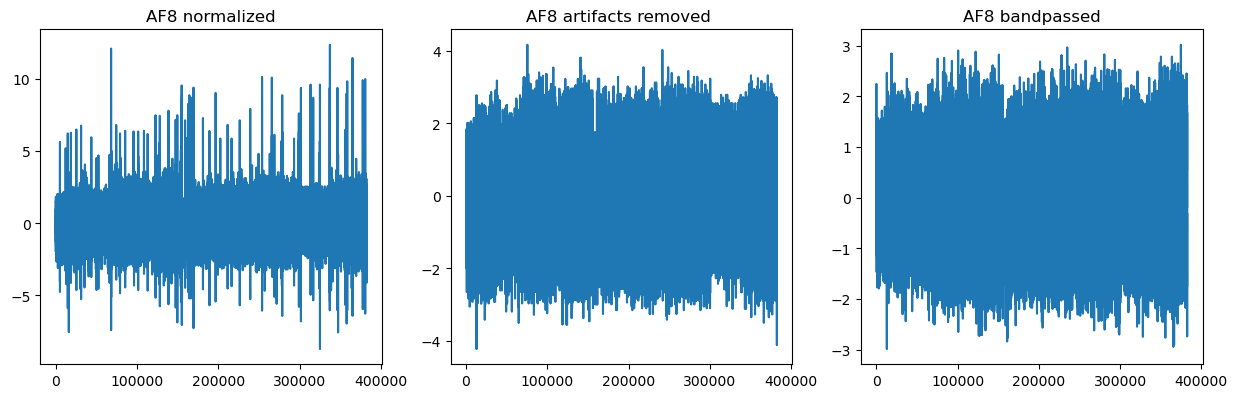

In [12]:
plot_preprocessing(channels, eeg_df=af8)

### Separate trials

In [13]:
# Separate preprocessed data back into individual trials
eeg_data_t1 = af8[af8['trial'] == 1].drop(columns=['trial'])
gradcpt_data_t1 = gradcpt_data[gradcpt_data['trial'] == 1].drop(columns=['trial'])

eeg_data_t2 = af8[af8['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t2 = gradcpt_data[gradcpt_data['trial'] == 2].drop(columns=['trial']).reset_index(drop=True)

eeg_data_t3 = af8[af8['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)
gradcpt_data_t3 = gradcpt_data[gradcpt_data['trial'] == 3].drop(columns=['trial']).reset_index(drop=True)

### Segmentation

In [14]:
segments_t1 = segment_column(eeg_data_t1['AF8_bandpassed'], gradcpt_data_t1)
segments_t2 = segment_column(eeg_data_t2['AF8_bandpassed'], gradcpt_data_t2)
segments_t3 = segment_column(eeg_data_t3['AF8_bandpassed'], gradcpt_data_t3)

### Discrete Wavelet Transform

In [15]:
segment_bands_t1 = [decompose_segment(segment) for segment in segments_t1]
segment_bands_t2 = [decompose_segment(segment) for segment in segments_t2]
segment_bands_t3 = [decompose_segment(segment) for segment in segments_t3]

### Extract features

In [16]:
channel = 'AF8'
features_t1 = extract_features(channel, segment_bands_t1)
features_t2 = extract_features(channel, segment_bands_t2)
features_t3 = extract_features(channel, segment_bands_t3)

features_t1['in_the_zone'] = gradcpt_data_t1['in_the_zone']
features_t2['in_the_zone'] = gradcpt_data_t2['in_the_zone']
features_t3['in_the_zone'] = gradcpt_data_t3['in_the_zone']

/home/henri/miniconda3/envs/training-env/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:589: UserWarning: nperseg = 256 is greater than input length  = 205, using nperseg = 205
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


In [17]:
combined_features_df = pd.concat([features_t1, features_t2, features_t3], ignore_index=True)

In [31]:
from detach_rocket.detach_rocket.detach_classes import DetachMatrix
from sklearn.model_selection import train_test_split

X = combined_features_df.iloc[:, :-1]
y = combined_features_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

detach_matrix = DetachMatrix()
detach_matrix.fit(X_train, y_train)

# Evaluate Performance on Test Set
detach_test_score, full_test_score= detach_matrix.score(X_test, y_test)
print('Test Accuraccy Full Model: {:.2f}%'.format(100*full_test_score))
print('Test Accuraccy Detach Model: {:.2f}%'.format(100*detach_test_score))

TRAINING RESULTS Full Features:
Optimal Alpha Full Features: 54555.95
Train Accuraccy Full Features: 58.41%
-------------------------
TRAINING RESULTS Detach Model:
Optimal Alpha Detach Model: 24.00
Train Accuraccy Detach Model: 62.98%
-------------------------
Test Accuraccy Full Model: 59.86%
Test Accuraccy Detach Model: 53.76%


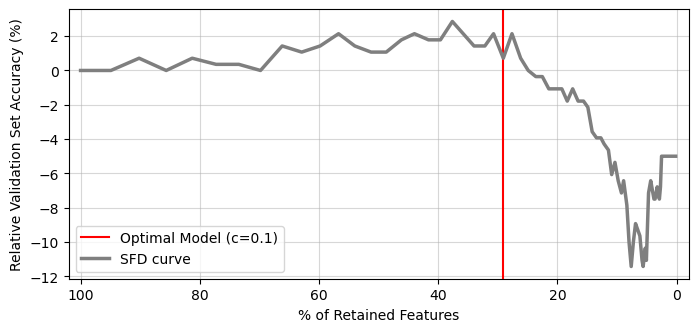

Optimal Model Size: 29.09% of full model


In [32]:
import matplotlib.pyplot as plt
percentage_vector = detach_matrix._percentage_vector
acc_curve = detach_matrix._sfd_curve

c = detach_matrix.trade_off

x=(percentage_vector) * 100
y=(acc_curve/acc_curve[0]-1) * 100

point_x = x[detach_matrix._max_index]
#point_y = y[DetachMatrixModel._max_index]

plt.figure(figsize=(8,3.5))
plt.axvline(x = point_x, color = 'r',label=f'Optimal Model (c={c})')
plt.plot(x, y, label='SFD curve', linewidth=2.5, color='C7', alpha=1)
#plt.scatter(point_x, point_y, s=50, marker='o', label=f'Optimal point (c={c})')

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlim(102,-2)
plt.xlabel('% of Retained Features')
plt.ylabel('Relative Validation Set Accuracy (%)')
plt.legend()
plt.show()

print('Optimal Model Size: {:.2f}% of full model'.format(point_x))

In [33]:
# Check if '_feature_mask' is available and use it to filter features
if hasattr(detach_matrix, '_feature_mask'):
    feature_mask = detach_matrix._feature_mask
    
    # Use the mask to select features from the training and test sets
    X_train_selected = X_train.loc[:, feature_mask]
    X_test_selected = X_test.loc[:, feature_mask]
else:
    print("Feature mask not found in DetachMatrix object.")

# Add the labels back to the selected feature sets
X_train_selected_with_labels = X_train_selected.assign(Label=y_train)
X_test_selected_with_labels = X_test_selected.assign(Label=y_test)

# Concatenate the training and test sets back into a single DataFrame
selected_features_df = pd.concat([X_train_selected_with_labels, X_test_selected_with_labels], ignore_index=True)

## Training

In [34]:
n_features = len(selected_features_df.columns)-1 # last col is the label
for feats in [5, 15, 20, 25, n_features]:
    print(f'---{feats} FEATURES---')
    print('Combined:')
    train(runs=5, num_features=feats, df=selected_features_df)

---5 FEATURES---
Combined:
Avg: 50.48%
---15 FEATURES---
Combined:
Avg: 50.56%
---20 FEATURES---
Combined:
Avg: 50.34%
---25 FEATURES---
Combined:
Avg: 50.1%
---169 FEATURES---
Combined:
Avg: 56.0%
